In [50]:
%pip install pandas firebase-admin python-dotenv sentence-transformers numpy matplotlib plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


## 1. Obtener y preprocesar los datos

### Conexión a Firebase

In [6]:
from dotenv import dotenv_values, find_dotenv

import firebase_admin # type: ignore
from firebase_admin import credentials, firestore

async def get_firestore_client():
    config = dotenv_values(find_dotenv())

    firebase_credentials_file_path = config["FIREBASE_CREDENTIALS"]
    cred = credentials.Certificate(firebase_credentials_file_path)

    if not firebase_admin._apps:
        firebase_admin.initialize_app(cred)

    db = firestore.client()

    return db

db = await get_firestore_client()
db

In [7]:
votaciones_docs = db.collection("votaciones").stream()
votaciones = list(map(lambda doc: doc.to_dict(), votaciones_docs))
votaciones

[{'fecha_str': '12/03/2013 19:55',
  'resultado': '',
  'boletin_numero': '6190-19',
  'id': 5000,
  'legislatura_id': 484,
  'url': 'https://www.senado.cl/appsenado/index.php?mo=sesionessala&ac=detalleVotacion&votaid=5000',
  'sesion_numero': 1,
  'tramite_constitucional': '',
  'detalle': {'NO': ['Alvear V., Soledad',
    'Cantero O., Carlos',
    'Chahuán C., Francisco',
    'Coloma C., Juan Antonio',
    'Espina O., Alberto',
    'García Huidobro S., Alejandro',
    'García R., José',
    'Kuschel S., Carlos Ignacio',
    'Larraín F., Hernán',
    'Larrain P., Carlos',
    'Novoa V., Jovino',
    'Orpis B., Jaime',
    'Pérez S., Lily',
    'Pizarro S., Jorge',
    'Prokurica P., Baldo',
    'Rincón G., Ximena',
    'Ruiz-Esquide J., Mariano',
    'Sabag C., Hosaín',
    'Uriarte H., Gonzalo',
    'Von Baer J., Ena',
    'Walker P., Ignacio',
    'Zaldívar L., Andrés'],
   'SI': ['Allende B., Isabel',
    'Girardi L., Guido',
    'Gómez U., José Antonio',
    'Muñoz A., Pedro',
   

### Agregar variables para fechas y filtrar votaciones entre marzo 2018 y marzo 2024

In [8]:
import pandas as pd

START_DATE = '11/03/2018'
END_DATE = '10/03/2024'

start_date = pd.to_datetime(f'{START_DATE} 00:00:00', format='%d/%m/%Y %H:%M:%S').date()
end_date = pd.to_datetime(f'{END_DATE} 23:59:59', format='%d/%m/%Y %H:%M:%S').date()

votaciones_df = pd.DataFrame(votaciones)

votaciones_df['fecha_str'].apply(lambda s: s.strip())
votaciones_df['fecha'] = pd.to_datetime(votaciones_df['fecha_str'], format='%d/%m/%Y %H:%M').dt.date

votaciones_df = votaciones_df[(votaciones_df['fecha'] >= start_date) & (votaciones_df['fecha'] <= end_date)].reset_index()

votaciones_df['legislatura_id'] = votaciones_df['legislatura_id'].astype(str)
votaciones_df['anio'] = votaciones_df['fecha'].apply(lambda d: str(d.year))
votaciones_df['boletin_numero'] = votaciones_df['boletin_numero'].apply(lambda w: w.replace('.', ''))
votaciones_df

index         fecha_str resultado boletin_numero    id legislatura_id  \
0      2066  13/03/2018 16:49                 11465-22  7134            489   
1      2067  14/03/2018 16:22                 10217-15  7135            489   
2      2068  14/03/2018 16:52                 11269-05  7136            489   
3      2069  14/03/2018 17:12                 10456-15  7137            489   
4      2070  14/03/2018 17:19                 10456-15  7138            489   
...     ...               ...       ...            ...   ...            ...   
2513   4579  05/03/2024 20:21                           9661            503   
2514   4580  06/03/2024 15:38                  2524-12  9662            503   
2515   4581  06/03/2024 16:23                 16576-08  9663            503   
2516   4582  06/03/2024 17:18                 16408-05  9664            503   
2517   4583  06/03/2024 17:41                 16302-04  9665            503   

                                                    url  sesion_numero  \
0     https://www.senado.cl/appsenado/index.php?mo=s...              1   
1     https://www.senado.cl/appsenado/index.php?mo=s...              2   
2     https://www.senado.cl/appsenado/index.php?mo=s...              2   
3     https://www.senado.cl/appsenado/index.php?mo=s...              2   
4     https://www.senado.cl/appsenado/index.php?mo=s...              2   
...                                                 ...            ...   
2513  https://www.senado.cl/appsenado/index.php?mo=s...            101   
2514  https://www.senado.cl/appsenado/index.php?mo=s...            103   
2515  https://www.senado.cl/appsenado/index.php?mo=s...            103   
2516  https://www.senado.cl/appsenado/index.php?mo=s...            103   
2517  https://www.senado.cl/appsenado/index.php?mo=s...            103   

     tramite_constitucional  \
0                             
1                             
2                             
3                             
4                             
...                     ...   
2513                          
2514                          
2515                          
2516                          
2517                          

                                                detalle  ...  articulo  \
0     {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...  ...             
1     {'NO': ['Allamand Z., Andrés', 'Aravena A., Ca...  ...             
2     {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...  ...             
3     {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...  ...             
4     {'NO': ['Guillier Á., Alejandro', 'Quintana L....  ...             
...                                                 ...  ...       ...   
2513  {'NO': ['Coloma C., Juan Antonio', 'Ebensperge...  ...             
2514  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...  ...             
2515  {'NO': [], 'SI': ['Aravena A., Carmen Gloria',...  ...             
2516  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...  ...             
2517  {'NO': ['Kuschel S., Carlos Ignacio'], 'SI': [...  ...             

      camara  tipo votos_no                quorum votos_si  \
0     SENADO              0        Mayoría simple       35   
1     SENADO             14        Mayoría simple       10   
2     SENADO              0  Cuatro séptimos Q.C.       37   
3     SENADO              0  Cuatro séptimos Q.C.       37   
4     SENADO              2        Mayoría simple       26   
...      ...   ...      ...                   ...      ...   
2513  SENADO              3                  Q.C.       36   
2514  SENADO              0        Mayoría simple       24   
2515  SENADO              0        Mayoría simple       32   
2516  SENADO              0                  Q.C.       37   
2517  SENADO              1        Mayoría simple       27   

                                                materia votos_abs       fecha  \
0     Perfecciona los beneficios otorgados a bombero...         0  2018-03-13   

## 2. Computar _embeddings_ y reducir dimensionalidad

In [9]:
from sentence_transformers import SentenceTransformer

transformer = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")
votaciones_df['materia_embeddings'] = votaciones_df['materia'].apply(transformer.encode)

/Users/oxfist/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/Users/oxfist/.pyenv/versions/3.12.2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



### Reducir dimensionalidad de _embeddings_ con t-SNE

In [10]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)

tsne_embeddings = tsne.fit_transform(np.stack(votaciones_df['materia_embeddings'].values))
votaciones_df['tsne_1'] = tsne_embeddings[:,0]
votaciones_df['tsne_2'] = tsne_embeddings[:,1]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


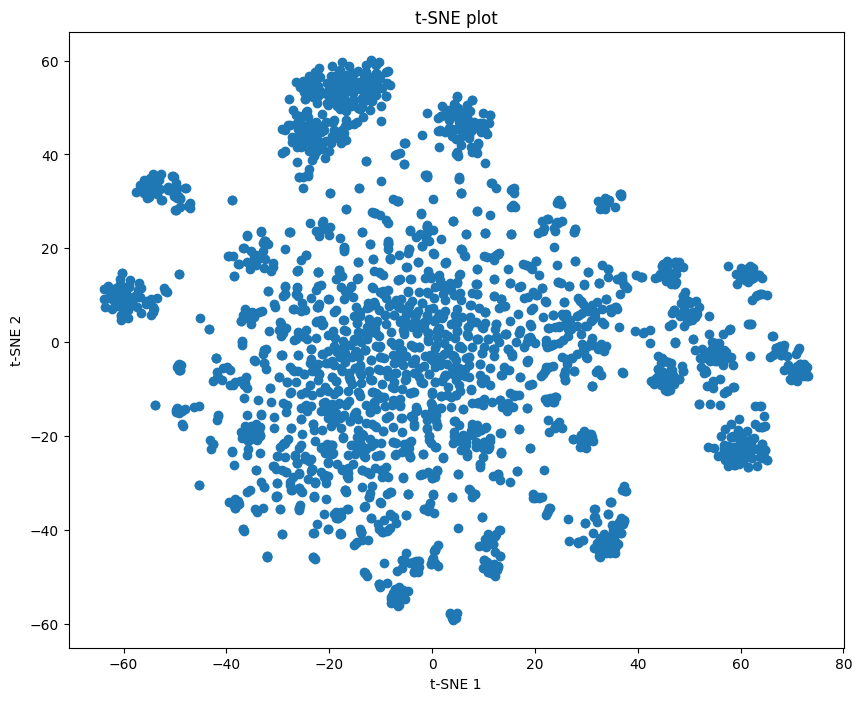

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(votaciones_df['tsne_1'], votaciones_df['tsne_2'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

## 3. Clusterizar _embeddings_ con K-means

In [12]:
from sklearn.cluster import KMeans

X = votaciones_df[['tsne_1', 'tsne_2']].values

kmeans = KMeans(n_clusters=30, random_state=42)
clusters = kmeans.fit_predict(X)

votaciones_df['kmeans_cluster'] = clusters
votaciones_df['kmeans_cluster']

0        3
1       10
2       16
3       20
4       20
        ..
2513    14
2514    23
2515     1
2516     1
2517     3
Name: kmeans_cluster, Length: 2518, dtype: int32

In [14]:
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import textwrap

def insert_br(s):
    return textwrap.fill(s, width=60).replace('\n', '<br>')

votaciones_df = votaciones_df.sort_values('kmeans_cluster')
votaciones_df['kmeans_cluster'] = votaciones_df['kmeans_cluster'].astype(str)
votaciones_df['materia_multiline'] = votaciones_df['materia'].apply(insert_br)

fig = px.scatter(
    votaciones_df,
    x='tsne_1',
    y='tsne_2',
    color='kmeans_cluster',
    custom_data=['materia_multiline', 'kmeans_cluster'],
    hover_data={
        'materia': True,
        'tsne_1': False,
        'tsne_2': False,
        'kmeans_cluster': False
    },
    title='Clusterización K-means de materias de votaciones del Senado (marzo 2018 - marzo 2024)',
)

hovertemplate = '<b>%{customdata[0]}</b><br><br>' + \
                'tsne_1: %{x}<br>' + \
                'tsne_2: %{y}<br>' + \
                'kmeans_cluster: %{customdata[1]}<extra></extra>'

fig.update_traces(hovertemplate=hovertemplate)

fig.update_layout(autosize=False, width=1000, height=800)
pio.write_html(fig, 'kmeans_clusters.html')

fig.show()

In [15]:
topic_counts = votaciones_df.groupby(['anio', 'kmeans_cluster']).size().unstack(fill_value=0)
topic_counts = topic_counts.reset_index()
topic_counts

kmeans_cluster  anio   0   1  10  11  12  13  14  15  16  ...  27  28  29   3  \
0               2018   2   3  10   1   0   1   5   9  13  ...  14   2  23   6   
1               2019   9   8  24   2  44   6   3   6  24  ...  33  10  21  10   
2               2020  44  21  18   0   0  19  27  14  18  ...  15  22   8  15   
3               2021  44  28  15   7   0  39   0   0  14  ...   4  21  16   4   
4               2022   0  17   9  23   0  33   5  48   3  ...   9  12   8  15   
5               2023   4  34  20  27   0  11  41   1   2  ...   4   9  14  25   
6               2024   0   7   1   4   0   0  27   0   0  ...   3   3   4   3   

kmeans_cluster   4   5   6   7   8   9  
0                7   0  17  21  10   0  
1                9   4   7   2  12   4  
2               20  36   8  10  21   0  
3               23   0   8   5  18   0  
4               21   0  13   4   6   0  
5               11   0  14  36   3  76  
6                2   0   2   0   2   0  

[7 rows x 31 columns]

In [16]:
cluster_labels = {
    '0': 'Indicaciones 1',
    # '1': '',
    '2': 'Solicitudes al Presidente/a 1',
    # '3': '',
    '4': 'Reformas electorales',
    '5': 'Migración',
    '6': 'Acuerdos Internacionales',
    '7': 'Reglamento Senado/Retiros AFP/Indicaciones',
    '8': 'Beneficios sociales/Pensiones alimentos y de gracia',
    '9': 'Indicaciones 2',
    '10': 'Sueldo mínimo/Protección medioambiental',
    '11': 'Estado excepción',
    '12': 'Indicaciones 3',
    # '13': '',
    '14': 'Votación artículos',
    '15': 'Presupuesto',
    '16': 'Inversión/Legislación bancaria',
    '17': 'Regulación transporte privado/Covid-19',
    '18': 'Indicaciones/Inadmisibilidad',
    '19': 'Oficios del Presidente/a',
    '20': 'Retiros AFP/Tipificación delitos',
    '21': 'Nueva Constitución/Reformas electorales',
    # '22': '',
    '23': 'Solicitudes al Presidente/a 2',
    '24': 'Indicaciones 4',
    '25': 'Derechos NNA',
    '26': 'Protección mediambiente/Derechos neurodivergencias',
    '27': 'Remuneraciones sector público/Educación',
    # '28': '',
    # '29': '',
}

df_melted = topic_counts.melt(id_vars='anio', var_name='cluster', value_name='Count')
df_melted['cluster_label'] = df_melted['cluster'].map(cluster_labels).fillna(df_melted['cluster'])
df_melted['cluster'] = df_melted['cluster'].astype(str)
df_melted['cluster'] = df_melted.groupby('anio')['cluster'].transform(
    lambda x: pd.Categorical(x, categories=x.groupby(x).sum().sort_values(ascending=False).index, ordered=True)
)
df_melted


anio cluster  Count   cluster_label
0    2018       0      2  Indicaciones 1
1    2019       0      9  Indicaciones 1
2    2020       0     44  Indicaciones 1
3    2021       0     44  Indicaciones 1
4    2022       0      0  Indicaciones 1
..    ...     ...    ...             ...
205  2020       9      0  Indicaciones 2
206  2021       9      0  Indicaciones 2
207  2022       9      0  Indicaciones 2
208  2023       9     76  Indicaciones 2
209  2024       9      0  Indicaciones 2

[210 rows x 4 columns]

In [17]:
fig = px.area(df_melted,
              x='anio',
              y='Count',
              color='cluster',
              pattern_shape='cluster',
              line_group='cluster',
              labels={'anio': 'Year', 'Count': 'Frequency', 'Cluster': 'Topic Cluster'},
              title='Frecuencia de Materia por Año (2018-2024)',
             )

fig.update_layout(
    xaxis_title='Año',
    yaxis_title='',
)
fig.update_layout(autosize=False, width=1000, height=600)

fig.show()

In [22]:
import plotly.graph_objects as go

fig = go.Figure()

unlabeled_clusters = ['1', '3', '13', '22', '28', '29']

for i, cluster in enumerate(df_melted['cluster_label'].unique()):
    df_cluster = df_melted[df_melted['cluster_label'] == cluster]
    if str(i) in unlabeled_clusters:
        fig.add_trace(go.Scatter(
            x=df_cluster['anio'],
            y=df_cluster['Count'],
            mode='lines',
            stackgroup='one',
            groupnorm='percent',
            line=dict(width=0.5, color="#C0C0C0"),
            hoveron="points+fills",
            hoverinfo='x+y+name',
            name=cluster,
        ))
    else:
        fig.add_trace(go.Scatter(
            x=df_cluster['anio'],
            y=df_cluster['Count'],
            mode='lines',
            stackgroup='one',
            groupnorm='percent',
            line=dict(width=0.5),
            hoveron="points+fills",
            hoverinfo='x+y+name',
            name=cluster,
        ))

fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(type='linear', range=[1, 100], dtick=20, ticksuffix='%'),
    title='Frecuencia de Materia por Año (2018-2024)',
    xaxis_title='Año',
    yaxis_title='Frecuencia de materia',
    autosize=False,
    width=1000,
    height=700
)
pio.write_html(fig, 'streamgraph.html')

fig.show()

## Extra

In [109]:
stream_data = topic_counts.reset_index().melt(id_vars='anio', var_name='topic', value_name='count')

# Create the streamgraph using Plotly
fig = px.area(stream_data, x='anio', y='count', color='topic', line_group='topic')
fig.update_layout(autosize=False, width=1000, height=800)
fig.show()

### Aplicar Non-negative Matrix Factorization para reducir dimensionalidad de _embeddings_

In [19]:
import numpy as np
from sklearn.decomposition import NMF

n_components = 6
mins = []

nmf = NMF(n_components=n_components, random_state=42)
# NMF requires non-negative values, so we calculate the minimum value to normalize embeddings.
min_value = np.min(votaciones_df['materia_embeddings'].tolist())

votaciones_df['normalized_embeddings'] = votaciones_df['materia_embeddings'] - min_value

W = nmf.fit_transform(votaciones_df['normalized_embeddings'].tolist())
H = nmf.components_

### Tokenizar materia para construir streamgraph

In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer, WordPunctTokenizer

nltk.download("stopwords")

stemmer = SnowballStemmer("spanish")
stop_words = set(stopwords.words("spanish"))
additional_stop_words = set([
  'acuerd',
  'acuerdo',
  'aprob',
  'aprobada',
  'aprobado',
  'articul',
  'articulo',
  'artículo',
  'bien',
  'boletin',
  'boletín',
  'comision',
  'comisión',
  'constitucional',
  'doña',
  'doñas',
  'establece',
  'general',
  'honor',
  'honorables',
  'indica',
  'inform',
  'ley',
  'modif',
  'modifica',
  'nacional',
  'nº',
  'part',
  'particul',
  'prim',
  'proyect',
  'proyecto',
  'public',
  'rechazada',
  'rechazado',
  'republ',
  'segunda',
  'segundas',
  'segundo',
  'senador',
  'senadora',
  'senadores',
  'señor',
  'señoras',
  'señores',
  'si',
  'solicit',
  'solicita',
  'tramit',
  'trámite',
  'va',
  'van',
  'votacion',
  'votación',
  'vs'
  'xv',
])

def filter_useful_tokens(token):
  return len(token) > 1 and token not in stop_words and token not in additional_stop_words and not token.isdigit()

def tokenize(observation):
  materia = observation['materia']
  tokenized_materia = RegexpTokenizer(r"\w+").tokenize(materia)
  tokenized_materia = WordPunctTokenizer().tokenize(" ".join(tokenized_materia))
  tokenized_materia = [token.lower() for token in tokenized_materia]
  tokenized_materia = list(filter(filter_useful_tokens, tokenized_materia))

  return tokenized_materia

votaciones_df['tokenized_materia'] = votaciones_df.apply(tokenize, axis=1)
votaciones_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oxfist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


fecha_str resultado boletin_numero    id legislatura_id  \
2066  13/03/2018 16:49                 11465-22  7134            489   
2067  14/03/2018 16:22                 10217-15  7135            489   
2068  14/03/2018 16:52                 11269-05  7136            489   
2069  14/03/2018 17:12                 10456-15  7137            489   
2070  14/03/2018 17:19                 10456-15  7138            489   
...                ...       ...            ...   ...            ...   
4579  05/03/2024 20:21                       NA  9661            503   
4580  06/03/2024 15:38                  2524-12  9662            503   
4581  06/03/2024 16:23                 16576-08  9663            503   
4582  06/03/2024 17:18                 16408-05  9664            503   
4583  06/03/2024 17:41                 16302-04  9665            503   

                                                    url  sesion_numero  \
2066  https://www.senado.cl/appsenado/index.php?mo=s...              1   
2067  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2068  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2069  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2070  https://www.senado.cl/appsenado/index.php?mo=s...              2   
...                                                 ...            ...   
4579  https://www.senado.cl/appsenado/index.php?mo=s...            101   
4580  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4581  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4582  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4583  https://www.senado.cl/appsenado/index.php?mo=s...            103   

     tramite_constitucional  \
2066                          
2067                          
2068                          
2069                          
2070                          
...                     ...   
4579                          
4580                          
4581                          
4582                          
4583                          

                                                detalle  sesion_id  ...  \
2066  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7979  ...   
2067  {'NO': ['Allamand Z., Andrés', 'Aravena A., Ca...       7981  ...   
2068  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7981  ...   
2069  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7981  ...   
2070  {'NO': ['Guillier Á., Alejandro', 'Quintana L....       7981  ...   
...                                                 ...        ...  ...   
4579  {'NO': ['Coloma C., Juan Antonio', 'Ebensperge...       9625  ...   
4580  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...       9627  ...   
4581  {'NO': [], 'SI': ['Aravena A., Carmen Gloria',...       9627  ...   
4582  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...       9627  ...   
4583  {'NO': ['Kuschel S., Carlos Ignacio'], 'SI': [...       9627  ...   

                    quorum  votos_si  \
2066        Mayoría simple        35   
2067        Mayoría simple        10   
2068  Cuatro séptimos Q.C.        37   
2069  Cuatro séptimos Q.C.        37   
2070        Mayoría simple        26   
...                    ...       ...   
4579                  Q.C.        36   
4580        Mayoría simple        24   
4581        Mayoría simple        32   
4582                  Q.C.        37   
4583        Mayoría simple        27   

                                                materia votos_abs       fecha  \
2066  Perfecciona los beneficios otorgados a bombero...         0  2018-03-13   
2067  Informe de la Comisión Mixta constituida para ...         0  2018-03-14   
2068  Proyecto de ley, en segundo trámite constituci...         0  2018-03-14   
2069  Proyecto de ley, iniciado en Moción del Honora...         0  2018-03-14   
2070  Proyecto de ley, en primer trámite constitucio...         1  2018-03-14   
...               

### Creación de nueva variable `most_common_materia_tokens` para construir streamgraph

In [48]:
from collections import Counter
from itertools import chain

votaciones_df['boletin_numero'] = votaciones_df['boletin_numero'].apply(lambda w: 'NA' if len(w) == 0 else w)
counter = Counter(chain.from_iterable(votaciones_df['tokenized_materia']))

def get_most_common_words(tokenized_materia):
    most_common_words = [word for word in tokenized_materia if word in counter]
    most_common_words.sort(key=counter.get, reverse=True)
    most_common_words = most_common_words[:6]
    return most_common_words

votaciones_df['most_common_materia_tokens'] = votaciones_df.apply(lambda row: get_most_common_words(row['tokenized_materia']), axis=1)
votaciones_df

fecha_str resultado boletin_numero    id legislatura_id  \
2066  13/03/2018 16:49                 11465-22  7134            489   
2067  14/03/2018 16:22                 10217-15  7135            489   
2068  14/03/2018 16:52                 11269-05  7136            489   
2069  14/03/2018 17:12                 10456-15  7137            489   
2070  14/03/2018 17:19                 10456-15  7138            489   
...                ...       ...            ...   ...            ...   
4579  05/03/2024 20:21                       NA  9661            503   
4580  06/03/2024 15:38                  2524-12  9662            503   
4581  06/03/2024 16:23                 16576-08  9663            503   
4582  06/03/2024 17:18                 16408-05  9664            503   
4583  06/03/2024 17:41                 16302-04  9665            503   

                                                    url  sesion_numero  \
2066  https://www.senado.cl/appsenado/index.php?mo=s...              1   
2067  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2068  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2069  https://www.senado.cl/appsenado/index.php?mo=s...              2   
2070  https://www.senado.cl/appsenado/index.php?mo=s...              2   
...                                                 ...            ...   
4579  https://www.senado.cl/appsenado/index.php?mo=s...            101   
4580  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4581  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4582  https://www.senado.cl/appsenado/index.php?mo=s...            103   
4583  https://www.senado.cl/appsenado/index.php?mo=s...            103   

     tramite_constitucional  \
2066                          
2067                          
2068                          
2069                          
2070                          
...                     ...   
4579                          
4580                          
4581                          
4582                          
4583                          

                                                detalle  sesion_id  ...  \
2066  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7979  ...   
2067  {'NO': ['Allamand Z., Andrés', 'Aravena A., Ca...       7981  ...   
2068  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7981  ...   
2069  {'NO': [], 'SI': ['Allamand Z., Andrés', 'Alle...       7981  ...   
2070  {'NO': ['Guillier Á., Alejandro', 'Quintana L....       7981  ...   
...                                                 ...        ...  ...   
4579  {'NO': ['Coloma C., Juan Antonio', 'Ebensperge...       9625  ...   
4580  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...       9627  ...   
4581  {'NO': [], 'SI': ['Aravena A., Carmen Gloria',...       9627  ...   
4582  {'NO': [], 'SI': ['Allende B., Isabel', 'Arave...       9627  ...   
4583  {'NO': ['Kuschel S., Carlos Ignacio'], 'SI': [...       9627  ...   

                    quorum  votos_si  \
2066        Mayoría simple        35   
2067        Mayoría simple        10   
2068  Cuatro séptimos Q.C.        37   
2069  Cuatro séptimos Q.C.        37   
2070        Mayoría simple        26   
...                    ...       ...   
4579                  Q.C.        36   
4580        Mayoría simple        24   
4581        Mayoría simple        32   
4582                  Q.C.        37   
4583        Mayoría simple        27   

                                                materia votos_abs       fecha  \
2066  Perfecciona los beneficios otorgados a bombero...         0  2018-03-13   
2067  Informe de la Comisión Mixta constituida para ...         0  2018-03-14   
2068  Proyecto de ley, en segundo trámite constituci...         0  2018-03-14   
2069  Proyecto de ley, iniciado en Moción del Honora...         0  2018-03-14   
2070  Proyecto de ley, en primer trámite constitucio...         1  2018-03-14   
...               

### Calcular frecuencias de cada término y normalizar

In [47]:
token_counts = votaciones_df.explode('most_common_materia_tokens') \
                            .groupby(['anio', 'most_common_materia_tokens']) \
                            .size() \
                            .reset_index(name='count')
# token_counts

anio_materia_frequency_df = token_counts.pivot(index='anio', columns='most_common_materia_tokens', values='count').fillna(0)
# anio_materia_frequency

normalized_frequencies_df = anio_materia_frequency_df.div(anio_materia_frequency_df.sum(axis=1), axis=0)
normalized_frequencies_df = normalized_frequencies_df.reset_index()

In [45]:
from datetime import datetime as dt
import plotly.express as px
import plotly.offline as pyo

long_df = normalized_frequencies_df.melt(id_vars='anio', var_name='keyword', value_name='frequency')
long_df['frequency'] *= 100

fig = px.area(long_df, x='anio', y='frequency', color='keyword',
              title='Actividad Legislativa del Senado de Chile',
              labels={'frequency': 'Porcentaje', 'anio': 'Año'},
              category_orders={"topic": sorted(long_df['keyword'].unique())},
              color_discrete_sequence=px.colors.qualitative.Plotly)

pyo.plot(fig, filename=f"{dt.now().strftime('%Y%m%d%H%M%S')}-streamgraph.html")

fig.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
